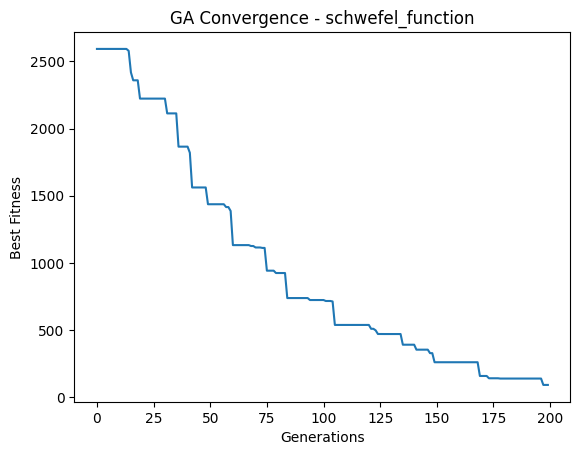

Final best fitness: 91.39319661043828
Crossover log uložen jako 'crossover_log.csv'


In [ ]:
import numpy as np
import random
import matplotlib.pyplot as plt
import pandas as pd
import os

individual_counter = 0  

crossover_log = []

def save_population_to_file(population, generation, filename="population_log_GA.csv"):
    df = pd.DataFrame([
        {"generation": generation, "id": int(ind[0]), **{f"gene_{i}": ind[i+1] for i in range(len(ind)-1)}}
        for ind in population
    ])

    df.to_csv(filename, mode="a", header=not os.path.exists(filename), index=False)

def initialize_population(pop_size, ind_size, bounds):
    global individual_counter
    population = []
    
    for _ in range(pop_size):
        genes = np.random.uniform(bounds[0], bounds[1], ind_size)
        population.append([individual_counter] + list(genes))
        individual_counter += 1
        
    return np.array(population)

def sphere_function(individual):
    return np.sum(np.square(individual[1:]))

def schwefel_function(individual):
    return 418.9829 * (len(individual) - 1) - np.sum(individual[1:] * np.sin(np.sqrt(np.abs(individual[1:]))))

def tournament_selection(population, fitnesses, k=3):
    selected = np.random.choice(len(population), k, replace=False)
    best = selected[np.argmin(fitnesses[selected])]
    return population[best]

def arithmetic_crossover(parent1, parent2):
    global individual_counter, crossover_log
    child1 = np.copy(parent1)
    child2 = np.copy(parent2)

    child1_id = individual_counter
    individual_counter += 1
    child2_id = individual_counter
    individual_counter += 1

    crossover_log.append([parent1[0], parent2[0], child1_id, child2_id])

    child1[0] = child1_id
    child2[0] = child2_id
    
    child1[1:] = 0.5 * parent1[1:] + 0.5 * parent2[1:]
    child2[1:] = 0.5 * parent2[1:] + 0.5 * parent1[1:]
    
    return child1, child2

def mutate(individual, mutation_rate, bounds):
    for i in range(1, len(individual)):
        if random.random() < mutation_rate:
            individual[i] = random.uniform(bounds[0], bounds[1])
    return individual

def evolve_population(population, elite_size, mutation_rate, fitness_func, bounds):
    fitnesses = np.array([fitness_func(ind) for ind in population])
    sorted_indices = np.argsort(fitnesses)
    
    new_population = population[sorted_indices][:elite_size]

    while len(new_population) < len(population):
        parent1 = tournament_selection(population, fitnesses)
        parent2 = tournament_selection(population, fitnesses)
        
        child1, child2 = arithmetic_crossover(parent1, parent2)
        child1 = mutate(child1, mutation_rate, bounds)
        child2 = mutate(child2, mutation_rate, bounds)
        
        new_population = np.vstack((new_population, child1, child2))

    return new_population[:len(population)]

def run_ga(pop_size, ind_size, generations, elite, mutation_rate, fitness_func, bounds):
    global crossover_log
    population = initialize_population(pop_size, ind_size, bounds)
    
    if os.path.exists("population_log_GA.csv"):
        os.remove("population_log_GA.csv")
    if os.path.exists("crossover_log.csv"):
        os.remove("crossover_log.csv")

    best_fitnesses = []
    
    for gen in range(1, generations + 1):
        save_population_to_file(population, gen)
        population = evolve_population(population, int(elite * pop_size), mutation_rate, fitness_func, bounds)
        fitnesses = np.array([fitness_func(ind) for ind in population])
        best_fitnesses.append(np.min(fitnesses))
    
    plt.plot(best_fitnesses)
    plt.title(f"GA Convergence - {fitness_func.__name__}")
    plt.xlabel("Generations")
    plt.ylabel("Best Fitness")
    plt.show()
    
    print(f"Final best fitness: {np.min(fitnesses)}")

    df_log = pd.DataFrame(crossover_log, columns=["Parent1", "Parent2", "Child1", "Child2"])
    df_log.to_csv("crossover_log.csv", index=False)
    print("Crossover log uložen jako 'crossover_log.csv'")
    
    return population

pop_size = 100
ind_size = 10
generations = 200
elite = 0.2
mutation_rate = 0.05
bounds = (-500, 500)

final_population = run_ga(pop_size, ind_size, generations, elite, mutation_rate, schwefel_function, bounds)